In [4]:
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde, gamma, uniform, rv_continuous, multivariate_normal
from scipy.linalg import cholesky, LinAlgError, eigvalsh, eigh, inv
from scipy.special import gamma as gamma_func
from scipy.special import kv
import matplotlib.pyplot as plt
import emcee as em
from schwimmbad import MPIPool
import sys
import os
from IPython.display import display, Math
import corner
from scipy.stats import gaussian_kde
import nfft

params = {'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.fontsize': 16,
          'font.size': 16,
          'legend.fancybox': True,
          'axes.grid': True}

plt.rcParams.update(params)

from IPython.display import display, Math

labels = ['s', 'l', 'p']

In [2]:
def round_sig(x, sig=1):
    """
    Rounds a float to the given number of significant
    figures.

    Parameters
    -------------
    x    : Float
           Float to be rounded
    sig  : Integer
           Number of sig. figures
    """

    i = sig-int(np.floor(np.log10(abs(x))))-1
    return np.around(x, i), i


def rbf(theta,x):
    
    return theta[0]**2 * np.exp(-0.5 * theta[1]**-2 * np.subtract.outer(x,x)**2)

def periodic(theta,x):
    
    return theta[0]**2 * np.exp(-2 * theta[1]**-2 * np.sin(np.pi * np.subtract.outer(x,x) / theta[2])**2)

def local_periodic(theta,x):
    
    return rbf(theta,x) * periodic(theta,x)

def matern(theta, x):
    
    if theta[1] > 18:
        return rbf([theta[0], theta[2]], x)
    else:
        u = np.sqrt(2 * theta[1]) * abs(np.subtract.outer(x,x) / theta[2])
        u[u == 0.0] += np.finfo(float).eps
        K = theta[0] * 2**(1-theta[1]) / gamma_func(theta[1]) * (u)**theta[1] * kv(theta[1], u)

        return K

def GP(kernel, theta, data, mu_prior=[], sigma=[]):
    
    
    # Define test points (XT) and training data (X, y)
    XT, X, y = data
    n = len(X)
    
    # Calculate cov. matrix for join distribution
    K = kernel(10**theta, np.concatenate((X, XT)))
    
    # For non-noisy training data set sigma = 0
    if len(sigma)==0:
        sigma = np.zeros(n)
    if len(mu_prior)==0:
        mu_prior = np.zeros(n)
    
    # Sub-matrices of joint distribution, using cholesky decomp. for inversion
    K_XTX = K[n:,:n]
    K_XX = K[:n,:n]+np.diag(sigma**2)
    try:
    	ch_K_XX = cholesky(K_XX, lower=True)
    except:
    	j = np.concatenate((X,XT))
    	u = np.sqrt(2 * theta[0]) * abs(np.subtract.outer(j,j) / theta[1])
    	u[u == 0.0] += np.finfo(float).eps
    	u = np.diag(u)
    	K_tmp = 2**(1-theta[0]) / gamma_func(theta[0]) * (u)**theta[0] * kv(theta[0], u)
    	print(u)
    	print(K_tmp)
    	print(np.count_nonzero(np.isnan(K_tmp)))

    K_XX_inv = inv(ch_K_XX.T) @ inv(ch_K_XX)#inv(K[:n,:n]+np.diag(sigma**2))
    K_XXT = K[:n,n:]
    K_XTXT = K[n:,n:]
    
    # Find conditioned mean function and covariance matrix
    m = K_XTX @ K_XX_inv @ (y-mu_prior)
    K = K_XTXT - K_XTX @ K_XX_inv @ K_XXT
    
    return (m, np.sqrt(np.diag(K)))

def plotposts(samples, kernel='RBF', **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    
    labels = {'RBF':[r'$\log_{10}(\sigma)$', r'$\log_{10}(l)$'],
              'Local_Periodic':[r'$\log_{10}(\sigma)$', r'$\log_{10}(l)$', r'$\log_{10}(p)$'],
              'Matern':[r'$\log_{10}(\sigma)$', r'$\log_{10}(\nu)$', r'$\log_{10}(l)$']}
    
    fig = corner.corner(samples, labels=labels[kernel], 
                        hist_kwargs={'density': True}, label_kwargs={'labelpad': 10000}, **kwargs)

In [3]:
samples_rbf = np.load('HPC_Results/B0105+64RBF.npy')
samples_per = np.load('HPC_Results/B0105+64Local_Periodic.npy')

Number of independent samples is 38500


<IPython.core.display.Math object>

<IPython.core.display.Math object>

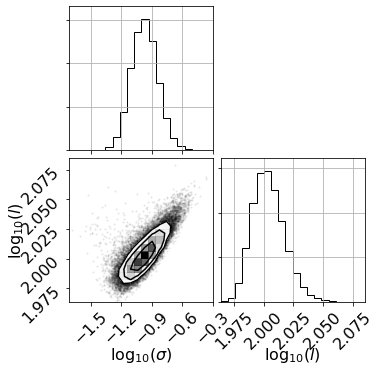

In [5]:
plotposts(samples_rbf)
print("Number of independent samples is {}".format(len(samples_rbf)))
plt.savefig('rbf_res.pdf')

for i in range(len(samples_rbf[0])):
    mcmc = np.percentile(10**samples_rbf[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Number of independent samples is 23900


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

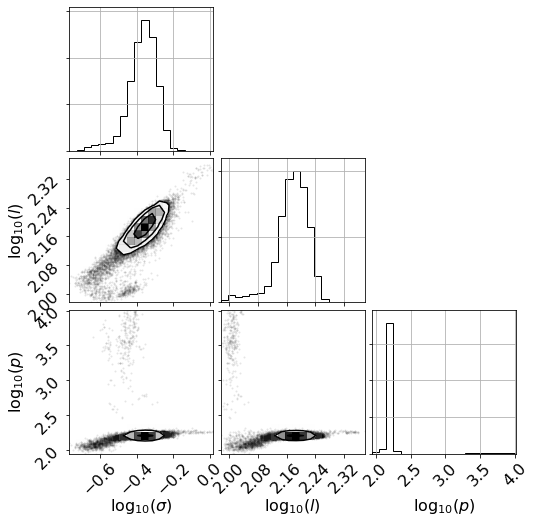

In [6]:
plotposts(samples_per, kernel='Local_Periodic')
print("Number of independent samples is {}".format(len(samples_per)))
plt.savefig('local_periodic_res.pdf')

for i in range(len(samples_per[0])):
    mcmc = np.percentile(10**samples_per[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [59]:
x = np.linspace(0,10,1000)
y_training = np.sin(x)[::350]
x_training = x[::350]
rbf_cov = rbf([1,1], x)
sigma = np.array([0.1,0.2,0.3])

gp_trained = GP(rbf, np.array([1.,1.]), [x, x_training, y_training], sigma=sigma)

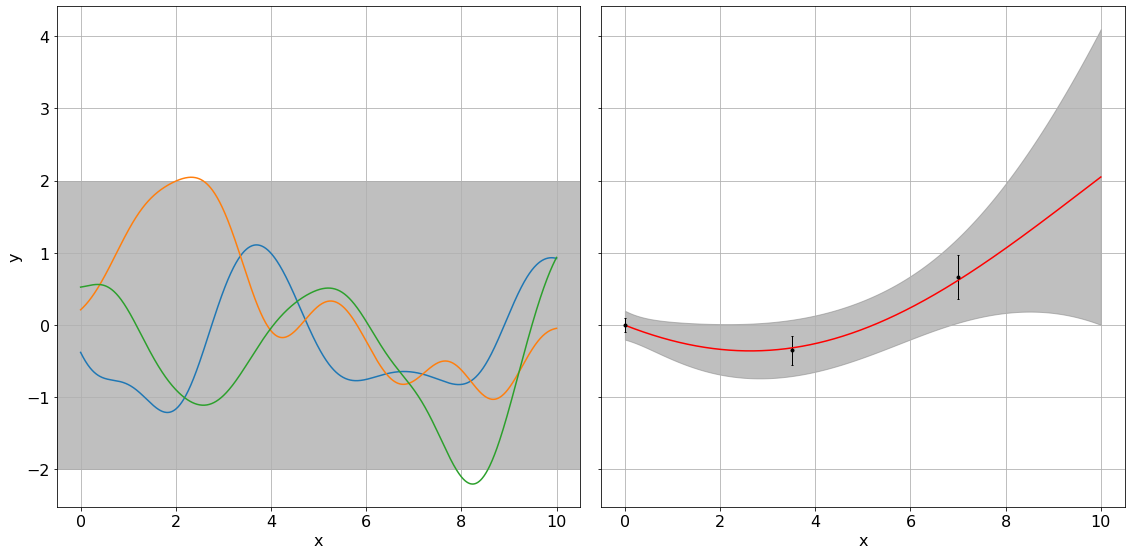

In [63]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharey=True)
ax1,ax2 = ax.flatten()
seeds = [42,420,69]

for i in range(3):
    np.random.seed(seeds[i])
    ax1.plot(x, multivariate_normal.rvs(cov=rbf_cov))

ax1.axhspan(-2,2, color='gray', alpha=0.5)
ax2.errorbar(x_training, y_training, yerr=sigma, fmt='.k', ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax2.plot(x, gp_trained[0], c='r')
ax2.fill_between(x, gp_trained[0]-2*gp_trained[1], gp_trained[0]+2*gp_trained[1], color='gray', alpha=0.5)

ax1.set(ylabel='y', xlabel='x')
ax2.set(xlabel='x')
fig.tight_layout()
plt.savefig('GP_training.pdf')

In [3]:
np.log(kv(1.2, 2.1))

-2.0119261900820122

## Lomb Scargle

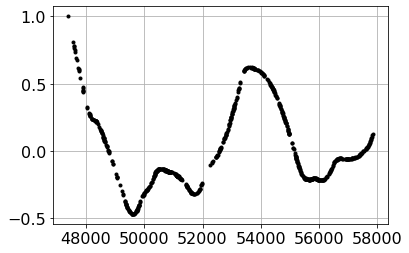

In [9]:
B0105 = np.loadtxt('Data/B0105+64.asc', usecols=(0,1,2,7))

plt.figure()
plt.plot(B0105[:,0], B0105[:,1], 'k.')

In [10]:
from astropy.timeseries import LombScargle

frequency, power = LombScargle(B0105[:,0], B0105[:,1]).autopower()

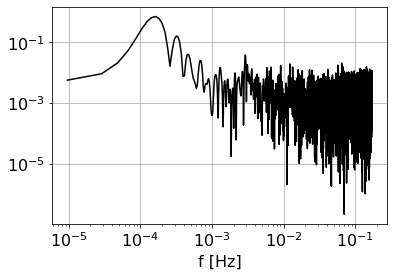

In [17]:
plt.loglog(frequency, power, c='k') 
plt.xlabel('f [Hz]')
plt.ylabel=('P(f)')
plt.savefig('psd.pdf')